In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg as LA
import random
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings('ignore')

# Mudanças realizadas:

1. Gradiente agora é Estocástico
2. Adição de Batch Size
3. Normalização dos Dados
4. Menos iterações para o fit nos dados de treino
5. Dimunuição do learning rate

In [2]:
train_redu = pd.read_csv('../dataset/train_redu.csv')
test_redu = pd.read_csv('../dataset/test_redu.csv')

### Normalização

In [3]:
scaler = MinMaxScaler()

#ajusta e transforma
train_redu_scaled = scaler.fit_transform(train_redu.drop('label', axis=1)) 
#transforma para evitar vazamento
test_redu_scaled = scaler.transform(test_redu.drop('label', axis=1)) 

train_redu['i_normalizada'] = train_redu_scaled[:,0]
train_redu['s_normalizada'] = train_redu_scaled[:,1]

test_redu['i_normalizada'] = test_redu_scaled[:,0]
test_redu['s_normalizada'] = test_redu_scaled[:,1]

In [4]:
#para testes
y_train_orig = train_redu['label']
y_test_orig = test_redu['label']

#normalizando
x_train = np.hstack((np.ones((len(train_redu), 1)), train_redu[['i_normalizada', 's_normalizada']].values))

x_test = np.hstack((np.ones((len(test_redu), 1)), test_redu[['i_normalizada', 's_normalizada']].values))
y_test = np.array([1 if y_ == 0 else -1 for y_ in test_redu['label']])


#escalonando
x_train_orig = scaler.inverse_transform(train_redu[['i_normalizada', 's_normalizada']].values)
x_train_orig = np.hstack((np.ones((len(train_redu), 1)), x_train_orig))

x_test_orig = scaler.inverse_transform(test_redu[['i_normalizada', 's_normalizada']].values)
x_test_orig = np.hstack((np.ones((len(test_redu), 1)), x_test_orig))

### Classes

In [5]:
class RegressaoLogistica():

    def __init__(self, learning_rate = 0.1, iterations = 10000, bs = 12):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.batch_size = bs

    def sigmoide(self, x):
        return 1/(1 + np.exp(-x))        

    def fit(self, X, Y):
        
        X = np.array(X)
        Y = np.array(Y)

        #numero de amostras
        m = X.shape[0]
        
        #numero de features
        n = X.shape[1]

        W = np.zeros(n, dtype = float)

        self.W = []
        
        
        for i in range(self.iterations):
            
            #vetor acumulador dos gradientes
            v_g = np.zeros(n, dtype = float)

            
            #caso o lote seja menor, escolher aleatoriamente uma nova mini-amostra
            if self.batch_size < m:

                indices = random.sample(range(m), self.batch_size)

                batch_x = [X[j] for j in indices]
                batch_y = [Y[j] for j in indices]

            else:
                batch_x = X
                batch_y = Y

            
            for x_, y_ in zip(batch_x, batch_y):
                
                #gradiente dos pesos atuais com sigmoide inversa
                v_g += (y_ * x_) / (1 + np.exp((y_ * W).T @ x_))

            #gradiente medio
            g_m = v_g / self.batch_size

            #condição de parada
            if LA.norm(g_m) < 0.0001:
                break

            #atualiza os pesos
            W += self.learning_rate * g_m

        self.W = W

    def predict(self, X):
        
        #probabilidade
        Z = np.dot(X, self.W)
        prob = np.exp(Z) / (1 + np.exp(Z))
                
        y_pred = np.where(prob >= 0.5, 1, -1)

        return y_pred
    
    def normaliza_y(self, x, shift = 0):
        return (-self.W[0] + shift - self.W[1] * x) / self.W[2]

In [6]:
def novo_df(X, y_pred):
  indices_to_keep = []
  for i in range(len(X)):
    if(np.array(y_pred[i]) == -1):
      indices_to_keep.append(i)
  return X.iloc[indices_to_keep]

In [7]:
import seaborn as sns

def plot(x_or, y_pred, data, modelo):

    xmin = x_or[:,1].min()
    xmax = x_or[:,1].max()

    sns.scatterplot(x='intensidade', y='simetria', hue=y_pred, data=data, palette='coolwarm', s=5)

    x = np.linspace(xmin, xmax, 100)

    x_normalized = scaler.transform(np.column_stack((x, np.zeros_like(x))))[:, 0]
    y_normalized = modelo.normaliza_y(x_normalized)

    y = scaler.inverse_transform(np.column_stack((x, y_normalized)))[:, 1]

    plt.plot(x, y, 'y-', label='g(.)')
    plt.legend(loc='upper right')
    plt.show()

In [8]:
def um_tds(train_redu, digitos=[0, 1, 4]):

    modelos = {}

    for i in digitos:
        
        x_train = train_redu[['i_normalizada', 's_normalizada']].values
        x_train = np.hstack((np.ones((len(x_train), 1)), x_train))

        y_train_norm = np.array([1 if y_ == i else -1 for y_ in train_redu['label']])

        x_train_orig = scaler.inverse_transform(train_redu[['i_normalizada', 's_normalizada']].values)
        x_train_orig = np.hstack((np.ones((len(train_redu), 1)), x_train_orig))

        rl = RegressaoLogistica()
        rl.fit(x_train, y_train_norm)
        y_pred_train = rl.predict(x_train)

        plot(x_train_orig, y_pred_train, train_redu, rl)

        modelos[i] = rl

        train_redu = novo_df(train_redu, y_pred_train)

    return modelos


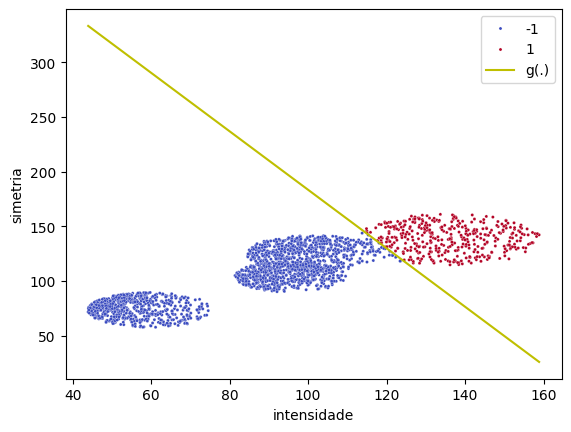

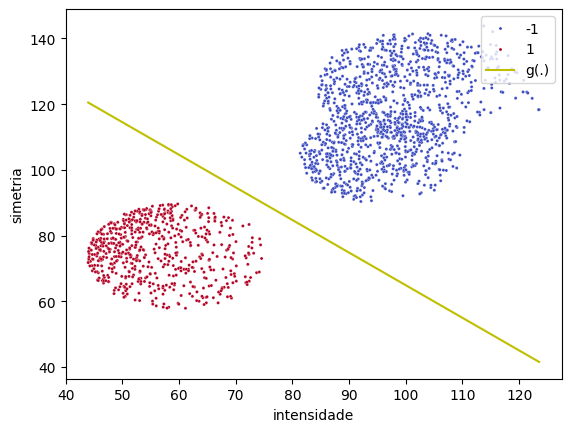

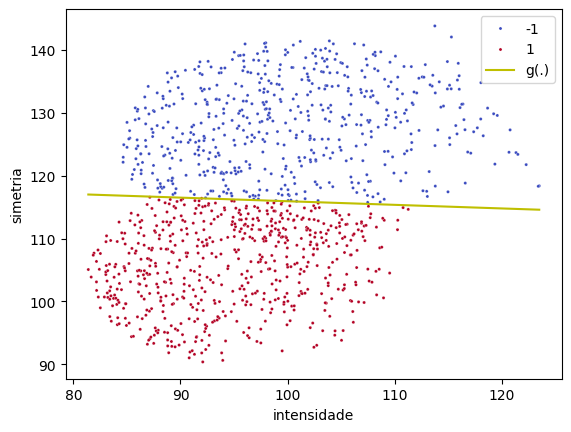

In [9]:
modelos = um_tds(train_redu)


In [10]:
def classe_0(x):
    pred = modelos[0].predict(x)
    return np.array(pred)

def classe_1(x):
    pred = modelos[1].predict(x)
    return np.array(pred)

def classe_4(x):
    pred = modelos[4].predict(x)
    return np.array(pred)

def classificador(x):
    if classe_0(x) == 1:
        return 0
    elif classe_1(x) == 1:
        return 1
    elif classe_4(x) == 1:
        return 4
    else:
        return 5  

In [11]:
pred_treino = [classificador(x) for x in x_train]

In [12]:
pred_teste = [classificador(x) for x in x_test]

### Vizualização Gráfica

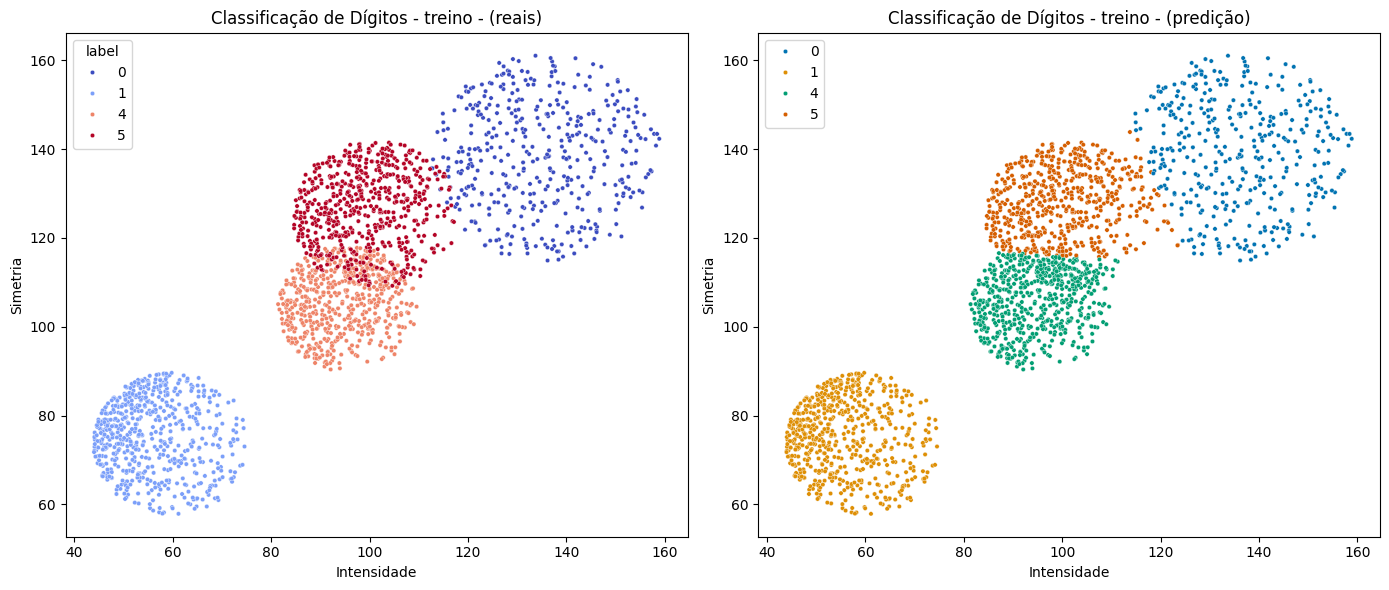

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x='intensidade', y='simetria', hue=train_redu['label'], data=train_redu, palette='coolwarm', s=10, marker='o')
axes[0].set_title('Classificação de Dígitos - treino - (reais)')
axes[0].set_xlabel('Intensidade')
axes[0].set_ylabel('Simetria')

sns.scatterplot(ax=axes[1], x='intensidade', y='simetria', hue=pred_treino, data=train_redu, palette='colorblind', s=10, marker='o')
axes[1].set_title('Classificação de Dígitos - treino - (predição)')
axes[1].set_xlabel('Intensidade')
axes[1].set_ylabel('Simetria')

plt.tight_layout()
plt.show()

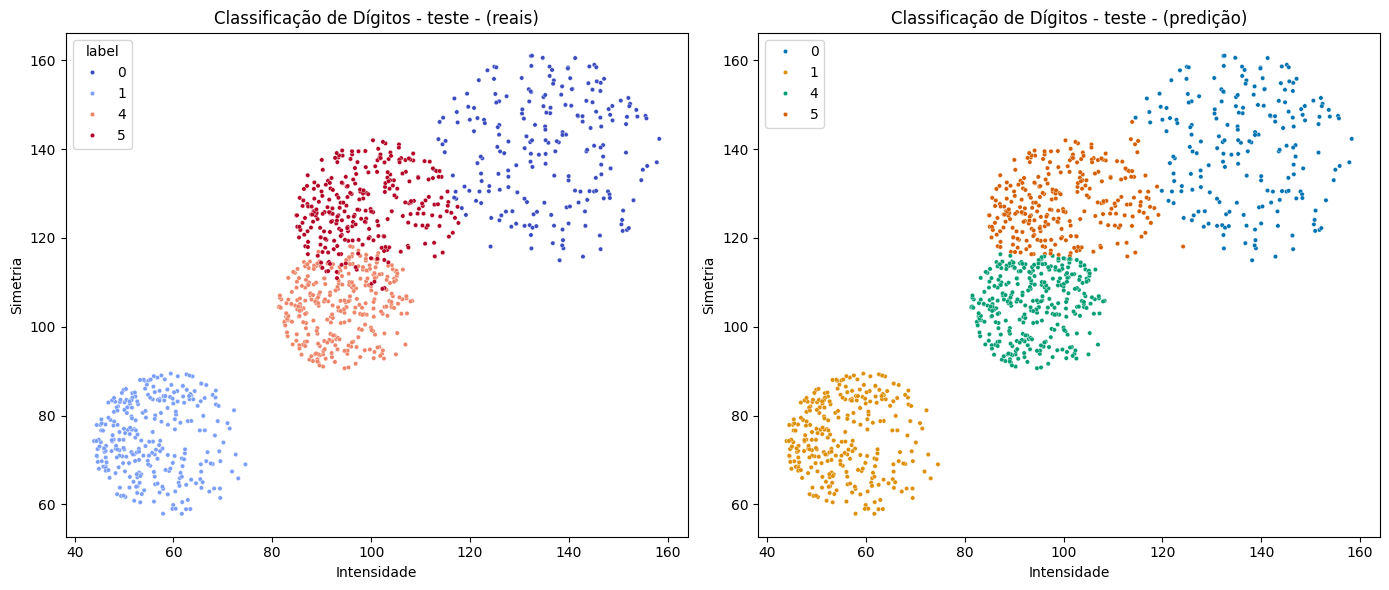

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(ax=axes[0], x='intensidade', y='simetria', hue=test_redu['label'], data=test_redu, palette='coolwarm', s=10, marker='o')
axes[0].set_title('Classificação de Dígitos - teste - (reais)')
axes[0].set_xlabel('Intensidade')
axes[0].set_ylabel('Simetria')

sns.scatterplot(ax=axes[1], x='intensidade', y='simetria', hue=pred_teste, data=test_redu, palette='colorblind', s=10, marker='o')
axes[1].set_title('Classificação de Dígitos - teste - (predição)')
axes[1].set_xlabel('Intensidade')
axes[1].set_ylabel('Simetria')

plt.tight_layout()
plt.show()

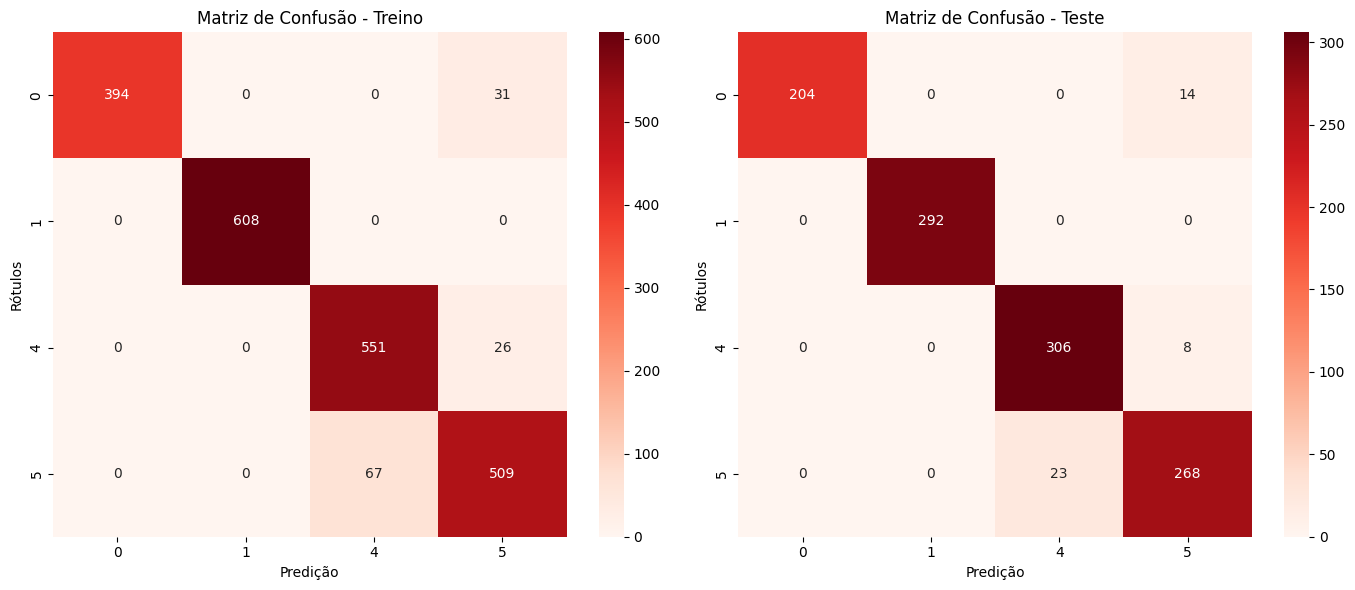

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

cm_train = confusion_matrix(y_train_orig, pred_treino)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['0', '1', '4', '5'], 
            yticklabels=['0', '1', '4', '5'], ax=axes[0])
axes[0].set_xlabel('Predição')
axes[0].set_ylabel('Rótulos')
axes[0].set_title('Matriz de Confusão - Treino')



cm_test = confusion_matrix(y_test_orig, pred_teste)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['0', '1', '4', '5'], 
            yticklabels=['0', '1', '4', '5'], ax=axes[1])
axes[1].set_xlabel('Predição')
axes[1].set_ylabel('Rótulos')
axes[1].set_title('Matriz de Confusão - Teste')

plt.tight_layout()
plt.show()


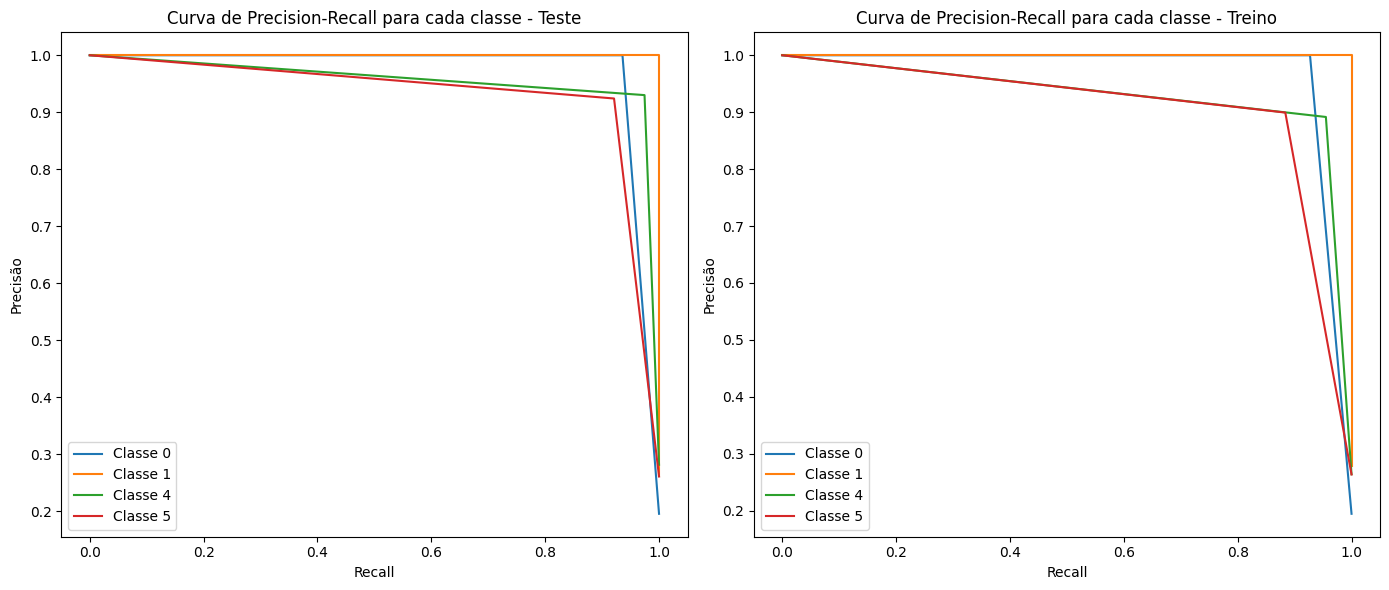

In [16]:
from sklearn.metrics import precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for class_label in np.unique(y_test_orig):
    y_true_binary = (y_test_orig == class_label).astype(int)
    y_pred_binary = (pred_teste == class_label).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_binary)
    
    axes[0].plot(recall, precision, label=f'Classe {class_label}')

axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precisão')
axes[0].set_title('Curva de Precision-Recall para cada classe - Teste')
axes[0].legend()

for class_label in np.unique(y_train_orig):
    y_true_binary = (y_train_orig == class_label).astype(int)
    y_pred_binary = (pred_treino == class_label).astype(int)

    precision, recall, thresholds = precision_recall_curve(y_true_binary, y_pred_binary)
    
    axes[1].plot(recall, precision, label=f'Classe {class_label}')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precisão')
axes[1].set_title('Curva de Precision-Recall para cada classe - Treino')
axes[1].legend()

plt.tight_layout()
plt.show()


## Eficiência da Classificação

In [17]:
pred_treino = np.array(pred_treino)
pred_teste = np.array(pred_teste)

train_accuracy = accuracy_score(y_train_orig.T, pred_treino)
print(f'Acurácia no treino: {train_accuracy*100:.2f}%')

test_accuracy = accuracy_score(y_test_orig.T, pred_teste)
print(f'Acurácia no teste: {test_accuracy*100:.2f}%')

Acurácia no treino: 94.33%
Acurácia no teste: 95.96%


In [18]:
N_in = len(train_redu)
eIn = 0
for i in range(N_in):
    if(pred_treino[i] != train_redu['label'][i]):
        eIn += 1
eIn /= N_in
print("Ein = " + str(eIn))


N_out = len(test_redu)
eOut = 0
for i in range(N_out):
    if(pred_teste[i] != test_redu['label'][i]):
        eOut += 1
eOut /= N_out
print("Eout = " + str(eOut))

Ein = 0.056724611161939616
Eout = 0.04035874439461883


In [19]:
print('Treino:')
print(classification_report(train_redu['label'].tolist(), pred_treino))

print('')

print('Teste:')
print(classification_report(test_redu['label'].tolist(), pred_teste))

Treino:
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       425
           1       1.00      1.00      1.00       608
           4       0.89      0.95      0.92       577
           5       0.90      0.88      0.89       576

    accuracy                           0.94      2186
   macro avg       0.95      0.94      0.94      2186
weighted avg       0.94      0.94      0.94      2186


Teste:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       218
           1       1.00      1.00      1.00       292
           4       0.93      0.97      0.95       314
           5       0.92      0.92      0.92       291

    accuracy                           0.96      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.96      0.96      0.96      1115



In [20]:
print('Metricas de Erro - Treino')
print("Erro médio quadrático: ", mean_squared_error(y_train_orig.T, pred_treino))
print("Erro médio absoluto: ", mean_absolute_error(y_train_orig.T, pred_treino))

print('')

print('Metricas de Erro - Teste')
print("Erro médio quadrático: ", mean_squared_error(y_test_orig.T, pred_teste))
print("Erro médio absoluto: ", mean_absolute_error(y_test_orig.T, pred_teste))

Metricas de Erro - Treino
Erro médio quadrático:  0.3970722781335773
Erro médio absoluto:  0.11344922232387923

Metricas de Erro - Teste
Erro médio quadrático:  0.3417040358744395
Erro médio absoluto:  0.09058295964125561


### Comparação com biblioteca pronta

Acuracia: 92.91%
Classificação:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       218
           1       1.00      1.00      1.00       292
           4       0.91      0.91      0.91       314
           5       0.87      0.86      0.86       291

    accuracy                           0.93      1115
   macro avg       0.93      0.93      0.93      1115
weighted avg       0.93      0.93      0.93      1115



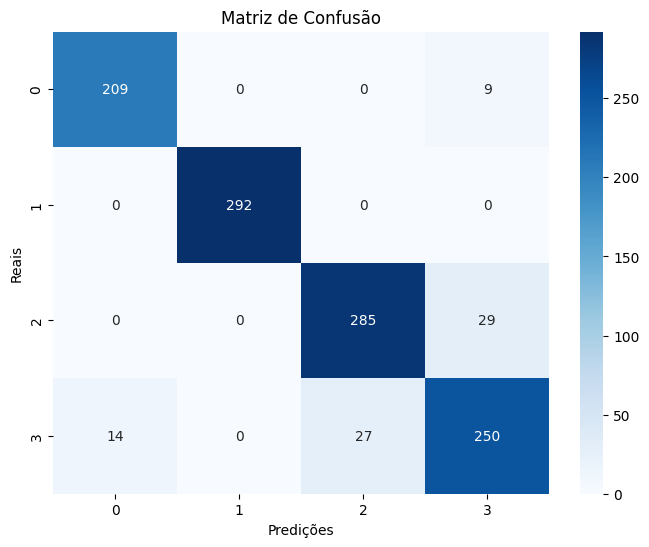

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = LogisticRegression()

model.fit(x_train_orig, y_train_orig)

y_pred = model.predict(x_test_orig)

accuracy = accuracy_score(y_test_orig, y_pred)

cm = confusion_matrix(y_test_orig, y_pred)

report = classification_report(y_test_orig, y_pred)

print(f'Acuracia: {accuracy*100:.2f}%')
print('Classificação:')
print(report)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predições')
plt.ylabel('Reais')
plt.title('Matriz de Confusão')
plt.show()
